In [1]:
import utilities as ut
import construction as cs
import singleDatasetAnalysis as san
import multipleDatasetAnalysis as man
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

# Embedding SEMPLICE su tutti i datasets
## gap = 5000

NAME :  InVS13.dat
DIPARTMENTS:  ['DISQ' 'DMCT' 'DSE' 'SFLE' 'SRH']
# of graphs 89
MAX size clique:  79


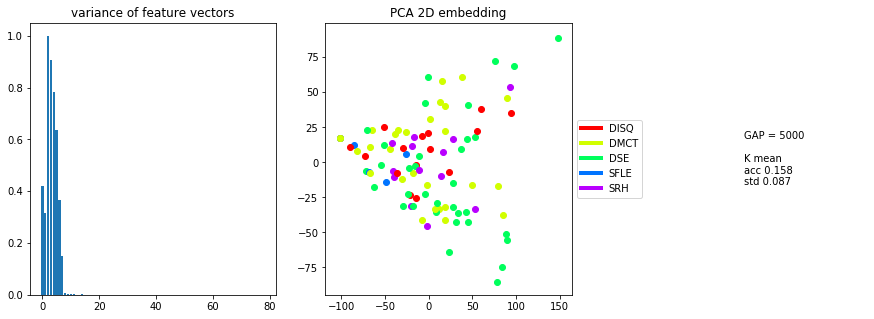

NAME :  InVS15.dat
DIPARTMENTS:  ['DCAR' 'DG' 'DISQ' 'DMCT' 'DMI' 'DSE' 'DST' 'SCOM' 'SDOC' 'SFLE' 'SRH'
 'SSI']
# of graphs 90
MAX size clique:  93


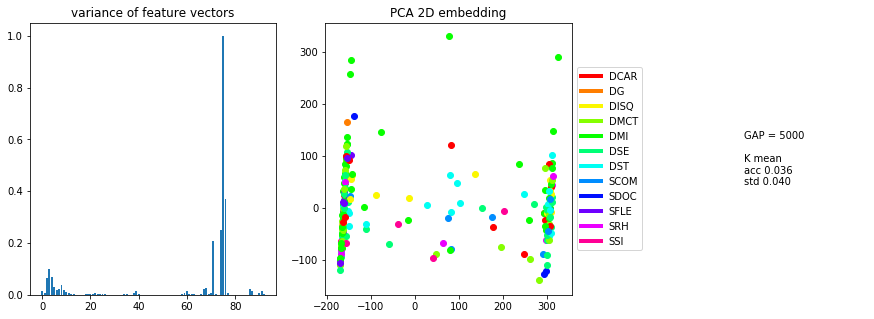

NAME :  LH10.dat
DIPARTMENTS:  ['Admin' 'Etude' 'Med' 'Paramed' 'Patient']
# of graphs 52
MAX size clique:  20


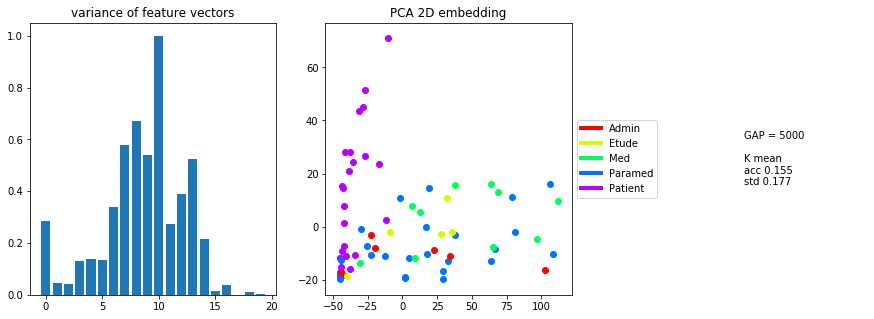

NAME :  Thiers13.dat
DIPARTMENTS:  ['2BIO1' '2BIO2' '2BIO3' 'MP' 'MPst1' 'MPst2' 'PC' 'PCst' 'PSIst']
# of graphs 39
MAX size clique:  102


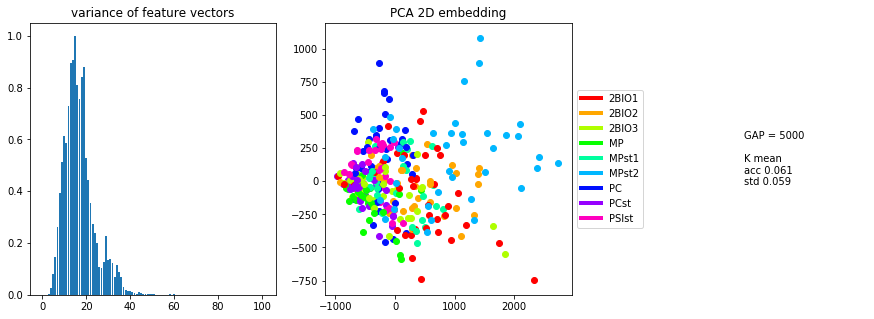

NAME :  LyonSchool.dat
DIPARTMENTS:  ['ce1a' 'ce1b' 'ce2a' 'ce2b' 'cm1a' 'cm1b' 'cm2a' 'cm2b' 'cpa' 'cpb'
 'teachers']
# of graphs 14


In [ ]:
names = ["InVS13.dat", "InVS15.dat", "LH10.dat", "Thiers13.dat","LyonSchool.dat"]
path_data = "data/co-presence/"
path_meta = "data/co-presence/metadata/metadata_"

for name in names:
    print("NAME : ",name)
    data_in = cs.load_data(path_data+name)
    metadata_in = path_meta+name
    
    meta_dict = load_metadata(metadata_in)
    dict_colors = compute_colors(meta_dict)
    gap = 5000
    data = data_in    
    graphs,pos = cs.build_graphs(data,gap)
    print("# of graphs "+str(len(graphs)))
    
    dict_cliques_frequences = node_fequences_cliques_time(graphs)
    size_max_clique = get_max_clique_size(dict_cliques_frequences)
    
    # get embedding and labels
    embeddings = build_embedding(dict_cliques_frequences,size_max_clique)
    labels = comute_labels(dict_cliques_frequences,meta_dict)
    
    plot_embedding_PCA_Kmean(embeddings,labels,dict_cliques_frequences,dict_colors,meta_dict,gap)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate

def Kmean_10cv(embeddings,Y,meta_dict):
    X_train, X_test, y_train, y_test = train_test_split(embeddings, Y, test_size=0.33, random_state=42)
    n_classes = len(np.unique(list(meta_dict.values())))


    scoring = ['accuracy']
    clf = KMeans(n_clusters=n_classes, random_state=0)
    scores = cross_validate(clf, embeddings, Y, scoring=scoring, cv=10)
    
    return (np.mean(scores['test_accuracy']),np.std(scores['test_accuracy'])) 


from sklearn.decomposition import PCA
from matplotlib.lines import Line2D


def plot_embedding_PCA_Kmean(embeddings,Y,dict_cliques_frequences,dict_colors,meta_dict,gap):
    # k mean
    acc, std = Kmean_10cv(embeddings,Y,meta_dict)


    # pca fro the plot
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(embeddings)

    features_variances = np.var(embeddings,0)/np.max(np.var(embeddings,0))


    plt.figure(figsize=(15,5))


    plt.subplot(131)
    plt.bar(range(len(features_variances)),features_variances)
    plt.title("variance of feature vectors")

    # plot 2D embeding
    plt.subplot(132)
    nodes = list(dict_cliques_frequences.keys())
    c = 0
    for i,j in emb_2d:
        plt.scatter(i,j,color=dict_colors[meta_dict[nodes[c]]])
        c = c + 1
    plt.title("PCA 2D embedding")


    # build legend
    custom_legend = []
    custom_departmenst = []
    for i in np.unique(list(meta_dict.values())):
        custom_departmenst.append(i)
        custom_legend.append(Line2D([0], [0], color=dict_colors[i], lw=4))

    plt.legend(custom_legend, np.unique(list(meta_dict.values())),loc='center left', bbox_to_anchor=(1, 0.5))
    title = "GAP = "+str(gap)+"\n\nK mean\nacc "+"{0:.3f}".format(acc)+"\nstd "+"{0:.3f}".format(std)
    plt.subplot(133)
    plt.text(0.5,0.5, title,
            horizontalalignment='left',
            verticalalignment='center',
            fontsize=10, color='black')
    plt.axis('off')
    plt.show()


In [3]:
def comute_labels(dictionary,meta_dict):
    Y = []
    temp_dictionary = dict()
    #initialize temp_dictionary
    counter = 1
    for i in np.unique(list(meta_dict.values())):
        if not(i in temp_dictionary):
            temp_dictionary[i] = counter
            counter = counter + 1


    for node in list(dictionary.keys()):  
        #print(meta_dict[node])
        Y.append(temp_dictionary[meta_dict[node]])
    return(Y)

def build_embedding(dictionary,size_max_clique):
    # matrice embeddings = 0
    embeddings = np.zeros((len(dictionary),size_max_clique))
    
    # riscrivili sulla matrice
    # pos i,j = k
    # il nodo i ha k cricche di dimensione j
    i = 0
    for node in list(dictionary.keys()):
        dic_node = dictionary[node]
        j = 0
        for clique_size in list(dic_node.keys()):
            embeddings[i][clique_size-1] = dic_node[clique_size]
            j = j + 1
        i = i + 1

    return(embeddings)

def get_max_clique_size(dictionary):
    
    # find max dim cricca, per creare matrice embeddings
    size_max_clique = 0
    for i in list(dictionary.keys()):
        for j in list(dictionary[i].keys()):
            if j > size_max_clique:
                size_max_clique = j
    print("MAX size clique: ",size_max_clique)
    return(size_max_clique)

def node_fequences_cliques_time(graphs):
    dictionary = dict()
    for n in graphs[0].nodes():
        dictionary[n] = dict()
        
    for g in graphs:
        for node in g.nodes():
            #dictionary[node] = dict()
            cliques = nx.cliques_containing_node(g,node)
            for clique in cliques:
                if (len(clique) in dictionary[node]):
                    dictionary[node][len(clique)] = dictionary[node][len(clique)] + 1
                else: 
                    dictionary[node][len(clique)] = 1
                    
                    
    return(dictionary)
    

In [4]:
def load_metadata(path):
    '''
    Input METADATA PATH
    Output dictionary {node_ID : "Dipartment",...}
    '''
    fp = open(path, 'r')
    meta_dict = dict()
    for line in fp.readlines():
        meta_dict[int(line.split("\t")[0])] = line.split("\t")[1][0:-1]

    fp.close()  
    print("DIPARTMENTS: ",np.unique(list(meta_dict.values())))
    return(meta_dict)

def compute_colors(meta_dict):
    '''
    Input metadata dictionary {node_ID : "Dipartment",...}
    Output colors dictionary {"Dipartment": "color"}
    '''
    departments = np.unique(list(meta_dict.values()))
    colors = get_cmap(len(departments))
    dict_colors = dict()
    for i in range(len(departments)):
        dict_colors[departments[i]] = colors(i)
        
        
    return(dict_colors)


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n+1)


In [5]:
def get_number_conected_components(graphs):
    count = 0

    sg = list(nx.connected_component_subgraphs(graphs))
    sub_graphs = []

    for i in sg:
        if not(len(i)==1):
            count = count + 1
                
    return(count)
def get_conncted_components(data,gap):
    graphs,pos = cs.build_graphs(data,
                   gap = gap)
    
    array_of_subgraphs = []
    
    for g in graphs:
        sg = list(nx.connected_component_subgraphs(g))
        sub_graphs = []

        for i in sg:
            if not(len(i)==1):
                sub_graphs.append(i)
                
        array_of_subgraphs.append(sub_graphs)
        
    return(array_of_subgraphs)